## Importing libraries

In [1]:
import pandas as pd
import numpy as np

import time
from tqdm import tqdm_notebook

In [2]:
import glob

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [4]:
import seaborn as sns

In [5]:
from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [6]:
pd.plotting.register_matplotlib_converters()

In [8]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [9]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [10]:
import dask.dataframe as dd

## Grouping neighborhoods for demand predictions

Import demand neighborhood hourly data

In [14]:
demand = pd.read_csv("nyc_neighborhoods_yellow_neigh_demand_hourly.csv", parse_dates = ['ds'])

In [16]:
demand.head()

,ds,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,59,172,110,104,99
0,2018-01-01 00:00:00,NaN,NaN,1.0,87.0,NaN,NaN,41.0,NaN,NaN,...,33.0,181.0,462.0,394.0,14.0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,NaN,NaN,1.0,154.0,NaN,NaN,100.0,NaN,1.0,...,70.0,156.0,596.0,475.0,11.0,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,NaN,NaN,NaN,153.0,1.0,NaN,133.0,NaN,NaN,...,81.0,94.0,442.0,362.0,20.0,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,1.0,NaN,NaN,101.0,NaN,NaN,107.0,NaN,NaN,...,27.0,53.0,333.0,275.0,25.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,3.0,NaN,NaN,77.0,NaN,NaN,106.0,NaN,NaN,...,18.0,24.0,225.0,219.0,23.0,NaN,NaN,NaN,NaN,NaN


In [17]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Columns: 265 entries, ds to 99
dtypes: datetime64[ns](1), float64(264)
memory usage: 17.7 MB


In [26]:
demand = demand.set_index('ds')

Taxi zone lookup table 

In [16]:
url_lookup = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv'

zone_lookup = pd.read_csv(url_lookup, index_col = 'LocationID')

In [17]:
zone_lookup.Borough.unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

In [18]:
zone_lookup.Borough.value_counts()

Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
Unknown           2
EWR               1
Name: Borough, dtype: int64

In [19]:
lst = [zone_lookup.loc[(int(demand.columns[i]))]['Zone'] for i,col in enumerate(demand.columns)]

In [20]:
zone_lookup.loc[249]

Borough            Manhattan
Zone            West Village
service_zone     Yellow Zone
Name: 249, dtype: object

In [21]:
lst_brooklyn = []
lst_queens = []
lst_manhattan = []
lst_staten = []
lst_bronx = []
for i, col in enumerate(demand.columns):
    bor = zone_lookup.loc[(int(demand.columns[i]))]['Borough']
    if bor == 'Queens':
        lst_queens.append(col)
    elif bor == 'Bronx':
        lst_bronx.append(col)
    elif bor == 'Manhattan':
        lst_manhattan.append(col)
    elif bor == 'Staten Island':
        lst_staten.append(col)
    elif bor == 'Brooklyn':
        lst_brooklyn.append(col)

### Manhattan

In [850]:
demand[lst_manhattan].isna().sum()

4        15
12     2094
13       30
24        7
41        1
42        7
43       14
45       97
48        1
50        1
68        1
74        1
75        1
79        1
87        2
88        8
90        1
100       1
105    8633
107       1
113       1
114       1
116      21
120    8258
125       3
127    3535
128    8054
137       1
140       1
141       1
       ... 
161       1
162       1
163       1
164       1
166       1
170       1
186       1
194    5431
202    5594
209      82
211       3
224      98
229       1
230       1
231       1
232      31
233       1
234       1
236       1
237       1
238       1
239       1
243    1586
244     105
246       1
249       1
261      15
262       2
263       1
104    8759
Length: 68, dtype: int64

For running meaningful prediction I need to group adjacent neighborhood where not enough data is available

In [872]:
manhattan_neigh = demand[lst_manhattan].copy().fillna(0)

'120', '127', '128','243' -> '244' washington heights

In [874]:
manhattan_neigh['243'] = (manhattan_neigh['120'] + manhattan_neigh['127'] + manhattan_neigh['128'] + manhattan_neigh['243'] + manhattan_neigh['244'] )

In [877]:
manhattan_neigh = manhattan_neigh.drop(['120', '127', '128', '244', '153'], axis = 1)

'12' -> '13' battery park

In [882]:
manhattan_neigh['13'] = (manhattan_neigh['12'] + manhattan_neigh['13'])

In [884]:
manhattan_neigh = manhattan_neigh.drop(['12'], axis = 1)

'194', '202' islands

'105', '104' islands

In [895]:
manhattan_neigh =  manhattan_neigh.drop(['194', '202', '105', '104'], axis = 1)

In [897]:
manhattan_neigh.head()

,4,13,24,41,42,43,45,48,50,68,...,236,237,238,239,243,246,249,261,262,263
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,87.0,63.0,71.0,94.0,43.0,399.0,57.0,673.0,251.0,495.0,...,432.0,593.0,402.0,571.0,56.0,200.0,427.0,33.0,181.0,462.0
2018-01-01 01:00:00,154.0,95.0,76.0,115.0,69.0,229.0,31.0,800.0,349.0,508.0,...,366.0,590.0,411.0,618.0,101.0,260.0,344.0,70.0,156.0,596.0
2018-01-01 02:00:00,153.0,45.0,36.0,138.0,91.0,106.0,57.0,862.0,339.0,392.0,...,236.0,284.0,253.0,380.0,108.0,211.0,279.0,81.0,94.0,442.0
2018-01-01 03:00:00,101.0,23.0,27.0,60.0,46.0,48.0,28.0,665.0,142.0,411.0,...,95.0,124.0,157.0,185.0,80.0,218.0,391.0,27.0,53.0,333.0
2018-01-01 04:00:00,77.0,17.0,33.0,50.0,38.0,8.0,18.0,518.0,93.0,294.0,...,34.0,58.0,100.0,101.0,54.0,203.0,287.0,18.0,24.0,225.0


In [995]:
manhattan_neigh.to_csv("./models/manhattan_neigh_demand.csv")

### Brooklyn

In [1006]:
demand[lst_brooklyn].isna().sum()

11     7656
14     4278
17     1768
21     7097
22     6360
25       37
26     5277
29     7362
33      470
34     6954
35     5333
36     4735
37     2292
39     5089
40      684
49     1009
52     1081
54     6049
55     7072
61     1305
62     4526
63     7252
65       78
66     1105
67     7382
71     5790
72     5819
76     3931
77     6900
80     1453
       ... 
89     2755
91     5607
97      117
106    2397
108    7633
111    8536
112    1003
123    6616
133    5304
149    7334
150    7800
154    8419
155    6584
165    6104
177    5529
178    7329
181     176
188    2212
189    1714
190    5630
195    5243
210    6716
217    4390
222    7122
225    3051
227    6727
228    3372
255     726
256     553
257    5798
Length: 61, dtype: int64

In [1067]:
brooklyn_neigh = demand.copy()[lst_brooklyn].fillna(0)

'34' -> '66'

In [1069]:
brooklyn_neigh['66'] = (brooklyn_neigh['34']+ brooklyn_neigh['66'])

In [1070]:
brooklyn_neigh = brooklyn_neigh.drop(['34'], axis = 1)

'11', '22', '67', '21' -> '14'

In [1072]:
brooklyn_neigh['14'] = (brooklyn_neigh['11']+ brooklyn_neigh['22']+ brooklyn_neigh['67']+ brooklyn_neigh['14']+ brooklyn_neigh['21'])

In [1073]:
brooklyn_neigh = brooklyn_neigh.drop(['11', '22', '67', '21'], axis = 1)

'26', '227', '133', '111', '257' -> '228'

In [1075]:
brooklyn_neigh['228'] = (brooklyn_neigh['26']+ brooklyn_neigh['227']+ brooklyn_neigh['133']+ brooklyn_neigh['111']+ brooklyn_neigh['257']+ brooklyn_neigh['228'])

In [1076]:
brooklyn_neigh = brooklyn_neigh.drop(['26', '227', '133', '111', '257'], axis = 1)

'29', '150', '108', '154', '210', '123', '149', '155' -> '55'

In [1078]:
brooklyn_neigh['55'] = (brooklyn_neigh['29']+ brooklyn_neigh['150']+ brooklyn_neigh['55']+ brooklyn_neigh['108']+ brooklyn_neigh['154']+ brooklyn_neigh['210']+ brooklyn_neigh['123']+ brooklyn_neigh['149']+ brooklyn_neigh['155'])

In [1079]:
brooklyn_neigh = brooklyn_neigh.drop(['29', '150', '108', '154', '210', '123', '149', '155'], axis = 1)

'36' -> '37'

In [1081]:
brooklyn_neigh['37'] = (brooklyn_neigh['36']+ brooklyn_neigh['37'])

In [1082]:
brooklyn_neigh = brooklyn_neigh.drop(['36'], axis = 1)

'35', '77', '222', '63', '39' -> '76'

In [1084]:
brooklyn_neigh['76'] = (brooklyn_neigh['35']+ brooklyn_neigh['77']+ brooklyn_neigh['76']+ brooklyn_neigh['222']+ brooklyn_neigh['63']+ brooklyn_neigh['39'] )

In [1085]:
brooklyn_neigh = brooklyn_neigh.drop(['35', '77', '222', '63', '39'], axis = 1)

'52' -> '54'

In [1088]:
brooklyn_neigh['54'] = (brooklyn_neigh['54']+ brooklyn_neigh['52'])

'62' -> '61'

In [1091]:
brooklyn_neigh['61'] = (brooklyn_neigh['62']+ brooklyn_neigh['61'])

In [1092]:
brooklyn_neigh = brooklyn_neigh.drop(['52', '62'], axis = 1)

'72', '85', '188' -> '71'

In [1097]:
brooklyn_neigh['71'] = (brooklyn_neigh['71']+ brooklyn_neigh['72']+ brooklyn_neigh['85']+ brooklyn_neigh['188'])

In [1098]:
brooklyn_neigh = brooklyn_neigh.drop(['72', '85', '188'], axis = 1)

'91', '165', '178' -> '89'

In [1101]:
brooklyn_neigh['89'] = (brooklyn_neigh['91']+ brooklyn_neigh['165']+ brooklyn_neigh['178']+ brooklyn_neigh['89'])

In [1102]:
brooklyn_neigh = brooklyn_neigh.drop(['91', '165', '178'], axis = 1)

'177', '225' -> '37'

In [1106]:
brooklyn_neigh['37']= (brooklyn_neigh['177']+ brooklyn_neigh['225']+ brooklyn_neigh['37'])

In [1107]:
brooklyn_neigh = brooklyn_neigh.drop(['177', '225'], axis = 1)

'190' -> '181'

In [1110]:
brooklyn_neigh['181'] = (brooklyn_neigh['190']+ brooklyn_neigh['181'])

In [1111]:
brooklyn_neigh = brooklyn_neigh.drop(['190'], axis = 1)

'195' -> '40'

In [1114]:
brooklyn_neigh['40'] = (brooklyn_neigh['195']+ brooklyn_neigh['40'])

In [1115]:
brooklyn_neigh = brooklyn_neigh.drop(['195'], axis = 1)

'217' -> '256'

In [1117]:
brooklyn_neigh['256'] = (brooklyn_neigh['217']+ brooklyn_neigh['256'])

In [1118]:
brooklyn_neigh = brooklyn_neigh.drop(['217'], axis = 1)

In [1119]:
(brooklyn_neigh > 0).sum()

14     6372
17     6992
25     8723
33     8290
37     8221
40     8197
49     7751
54     7773
55     5966
61     7967
65     8682
66     7696
71     7785
76     7150
80     7307
89     7332
97     8643
106    6363
112    7757
181    8608
189    7046
228    7834
255    8034
256    8384
dtype: int64

In [1120]:
brooklyn_neigh.head()

,14,17,25,33,37,40,49,54,55,61,...,80,89,97,106,112,181,189,228,255,256
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2.0,7.0,18.0,11.0,19.0,7.0,7.0,5.0,1.0,7.0,...,24.0,2.0,5.0,3.0,15.0,24.0,8.0,8.0,41.0,32.0
2018-01-01 01:00:00,2.0,17.0,53.0,25.0,67.0,33.0,23.0,13.0,2.0,20.0,...,73.0,10.0,40.0,16.0,65.0,61.0,21.0,19.0,96.0,77.0
2018-01-01 02:00:00,5.0,22.0,38.0,12.0,110.0,18.0,24.0,12.0,0.0,20.0,...,78.0,6.0,27.0,9.0,64.0,69.0,18.0,21.0,117.0,99.0
2018-01-01 03:00:00,6.0,20.0,20.0,9.0,111.0,4.0,20.0,3.0,3.0,15.0,...,72.0,2.0,20.0,9.0,40.0,29.0,18.0,13.0,88.0,106.0
2018-01-01 04:00:00,4.0,17.0,21.0,6.0,97.0,8.0,15.0,1.0,2.0,14.0,...,60.0,2.0,10.0,8.0,28.0,19.0,8.0,11.0,73.0,56.0


In [1121]:
brooklyn_neigh.to_csv("./models/brooklyn_neigh_demand.csv")

### Queens

In [188]:
demand[lst_queens].isna().sum()

2      8689
7         1
8      7804
9      7953
10     1418
15     7919
16     7334
19     7349
27     8680
28     3797
30     8738
38     7588
53     7760
56     5334
57     8429
64     8031
70     2310
73     8323
82      962
83     2965
86     8063
92     5191
93     2986
95     2243
96     8490
98     7706
101    7586
102    7459
117    8165
121    6919
       ... 
139    7373
145      26
146      21
157    5122
160    7055
171    7491
173    6084
175    7789
179     182
180    7473
191    6410
192    7638
193     210
196    3824
197    4959
198    6076
201    8553
203    7176
205    6208
207    6104
215    3392
216    2794
218    6074
219    3845
223     254
226       1
252    7702
253    8480
258    7011
260     199
Length: 69, dtype: int64

In [29]:
queens_neigh = demand[lst_queens].copy().fillna(0)

In [31]:
(queens_neigh['2'] + queens_neigh['27'] + queens_neigh['201'] + queens_neigh['117'] + queens_neigh['86'] ).sum()

1802.0

In [32]:
queens_neigh = queens_neigh.drop(['2', '27', '201', '117', '86'], axis = 1)

In [89]:
queens_neigh = queens_neigh.drop(['30'], axis = 1)

'8' -> '179'

In [41]:
queens_neigh['179'] = ((queens_neigh['8'] + queens_neigh['179']))

In [42]:
queens_neigh = queens_neigh.drop(['8'], axis = 1)

'15', '16', '171', '252', '73', '53', '92', '192', '253' -> '9'

In [69]:
#concat murray hill, flushing
queens_neigh['9'] = (queens_neigh['9'] + queens_neigh['15'] + queens_neigh['16']  + queens_neigh['171'] + queens_neigh['252'] + queens_neigh['73'] + queens_neigh['53'] + queens_neigh['92'] + queens_neigh['192'] + queens_neigh['253'])

In [70]:
queens_neigh = queens_neigh.drop(['15', '16', '171', '252', '73', '53', '92', '192', '253'], axis = 1)

In [82]:
((queens_neigh['19'] + queens_neigh['101']+ queens_neigh['64']+ queens_neigh['175'])>0).sum()

3381

In [83]:
queens_neigh = queens_neigh.drop(['19', '101', '64', '175'], axis = 1)

'38', '122', '205', '122', '139', '203', '219', '218' -> '191'

In [107]:
queens_neigh['191'] = (queens_neigh['38'] + queens_neigh['191']+ queens_neigh['122']+ queens_neigh['205']+ queens_neigh['122']+ queens_neigh['139']+ queens_neigh['203']+ queens_neigh['219']+ queens_neigh['218'])

In [108]:
queens_neigh = queens_neigh.drop(['38', '122', '205', '122', '139', '203', '219', '218'], axis = 1)

'196', '93', '173', '56', '57' -> '95'

In [128]:
queens_neigh['95'] = (queens_neigh['56'] + queens_neigh['57'] + queens_neigh['173'] + queens_neigh['93'] + queens_neigh['95'] + queens_neigh['196'])

In [129]:
queens_neigh = queens_neigh.drop(['196', '93', '173', '56', '57'], axis = 1)

'96', '102', '160', '157', '82', '83' -> '198'

In [163]:
queens_neigh['198'] = ((queens_neigh['96'] + queens_neigh['102'] + queens_neigh['198'] + queens_neigh['160']+ queens_neigh['157']+ queens_neigh['82']+ queens_neigh['83']))

In [164]:
queens_neigh = queens_neigh.drop(['96', '102', '160', '157', '82', '83'], axis = 1)

In [173]:
((queens_neigh['98'] + queens_neigh['121']+ queens_neigh['131']+ queens_neigh['28']+ queens_neigh['135'] ) >0).sum()

6818

'121', '131', '28', '135', '207' -> '98'

In [174]:
queens_neigh['98'] = ((queens_neigh['98'] + queens_neigh['121']+ queens_neigh['131']+ queens_neigh['28']+ queens_neigh['135'] ))

In [175]:
queens_neigh = queens_neigh.drop(['121', '131', '28', '135', '207'], axis = 1)

'180', '258', '197', '134', '124' -> '216'

In [182]:
queens_neigh['216'] = ((queens_neigh['124'] + queens_neigh['180'] + queens_neigh['258'] + queens_neigh['216']+ queens_neigh['197']+ queens_neigh['134']))

In [185]:
queens_neigh = queens_neigh.drop(['180', '258', '197', '134', '124'], axis = 1)

'207' -> '260'

In [193]:
queens_neigh['260'] = (queens_neigh['207']+queens_neigh['260'])

In [194]:
queens_neigh = queens_neigh.drop(['207'], axis = 1)

In [195]:
queens_neigh.head()

,7,9,10,70,95,98,129,130,132,138,...,146,179,191,193,198,215,216,223,226,260
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,41.0,2.0,0.0,3.0,6.0,1.0,15.0,2.0,174.0,67.0,...,21.0,13.0,1.0,10.0,8.0,2.0,3.0,15.0,9.0,10.0
2018-01-01 01:00:00,100.0,4.0,1.0,4.0,15.0,1.0,37.0,0.0,133.0,8.0,...,29.0,38.0,0.0,8.0,39.0,2.0,2.0,35.0,31.0,19.0
2018-01-01 02:00:00,133.0,1.0,0.0,6.0,19.0,1.0,32.0,1.0,33.0,0.0,...,28.0,33.0,0.0,8.0,78.0,0.0,1.0,40.0,54.0,46.0
2018-01-01 03:00:00,107.0,3.0,1.0,1.0,19.0,2.0,69.0,1.0,26.0,0.0,...,33.0,20.0,2.0,6.0,38.0,1.0,1.0,18.0,39.0,30.0
2018-01-01 04:00:00,106.0,3.0,1.0,4.0,22.0,5.0,57.0,0.0,40.0,7.0,...,29.0,23.0,0.0,9.0,62.0,0.0,5.0,21.0,64.0,41.0


In [200]:
queens_neigh.to_csv("./models/queens_neigh_demand.csv")

## Neighborhood demand forecasting

In [201]:
def run_model_for_neigh(neigh, exog, add_regressor = False, date1='2018-11-12', date2 = '2018-11-17'):
    df = neigh.reset_index()
    df.columns = ['ds', 'y']
    df_exog = df.join(exog)
    num_pounts_to_pred = int((pd.to_datetime(date2)-pd.to_datetime(date1))/np.timedelta64(1, 'h'))
    train = df_exog[df_exog.ds < date1]
    test = df_exog[(df_exog.ds >= date1) & (df_exog.ds < date2)]
    m=Prophet(holidays=hol,yearly_seasonality=False, weekly_seasonality= True, daily_seasonality=True )
    for reg in add_regressor:
        m.add_regressor(reg)
    m.fit(train)
    future = m.make_future_dataframe(periods=num_pounts_to_pred, freq='h', include_history=False)
    for reg in add_regressor:
        future[reg] = test.reset_index()[reg]
        future = future.fillna(method = 'ffill')
    forecast = m.predict(future)
    train_pred = m.predict(train)
    scoreR2 = r2_score(test[:num_pounts_to_pred].y, forecast.yhat)
    scoreR2_train = r2_score(train.y, train_pred.yhat)
    scoreRMSE = np.sqrt(mse(test[:num_pounts_to_pred].y, forecast.yhat))
    return forecast.yhat

In [134]:
client = Client()

In [212]:
exog = pd.read_csv('date_weather_bike_hr_features_2018.csv')

exog = pd.get_dummies(exog.drop(['DATE'], axis=1))

exog.head()

,weekend,since_2018,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,...,0,0,1,0,0,0,0,0,0,0


In [215]:
hol = pd.read_csv('holidays-2018.csv')

### Queens

In [234]:
%%time
print(datetime.now())
output_fc_q_12 = []
for i in (queens_neigh):
    forecasted_series_q_12 = dask.delayed(run_model_for_neigh)(queens_neigh[i],
                                                               exog, add_regressor = ['weekend', 
                                                                                 'since_2018', 'demand',
                                                                                 'SNOW', 'WT01', 'TAVG'],
                                                               date1='2018-11-01', date2 = '2018-12-31')
    output_fc_q_12.append(forecasted_series_q_12)

print(datetime.now())

total_q_12 = dask.delayed(output_fc_q_12).compute()

print(datetime.now())

full_fc_df_q_12 = pd.concat(total_q_12,ignore_index=False,keys=queens_neigh.columns,axis=1)

print(datetime.now())

2019-12-01 17:18:56.180687
2019-12-01 17:18:56.194442
2019-12-01 17:30:13.928264
2019-12-01 17:30:14.067399
CPU times: user 1min 9s, sys: 11.9 s, total: 1min 21s
Wall time: 11min 17s


In [240]:
full_fc_df_q_12_date = full_fc_df_q_12.copy().set_index(queens_neigh['2018-11-01':'2018-12-30'].index)

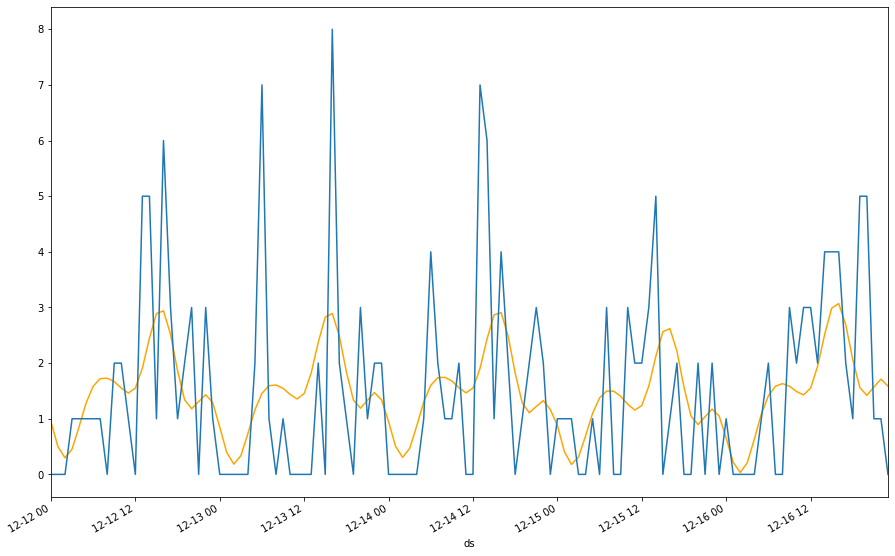

In [242]:
plt.figure(figsize = (15,10))
plt.plot(queens_neigh['2018-12-12':'2018-12-16'].index, full_fc_df_q_12_date['2018-12-12':'2018-12-16']['215'], color='orange')
queens_neigh['2018-12-12':'2018-12-16']['215'].plot()

In [243]:
full_fc_df_q_12_date.to_csv("./models/queens_neigh_demand_forecast_date_12.csv")

### Manhattan

In [244]:
manhattan_neigh_demand = pd.read_csv("./models/manhattan_neigh_demand.csv", parse_dates = ['ds'], index_col ='ds')

In [246]:
manhattan_neigh_demand.tail()

,4,13,24,41,42,43,45,48,50,68,...,236,237,238,239,243,246,249,261,262,263
ds,,,,,,,,,,,,,,,,,,,,,
2018-12-31 19:00:00,30.0,123.0,69.0,85.0,37.0,113.0,38.0,498.0,153.0,354.0,...,511.0,436.0,441.0,525.0,61.0,152.0,231.0,84.0,264.0,485.0
2018-12-31 20:00:00,39.0,100.0,81.0,96.0,54.0,138.0,40.0,533.0,131.0,346.0,...,460.0,451.0,385.0,483.0,55.0,164.0,267.0,101.0,230.0,460.0
2018-12-31 21:00:00,57.0,95.0,76.0,123.0,65.0,83.0,35.0,455.0,133.0,302.0,...,455.0,451.0,371.0,444.0,60.0,148.0,290.0,60.0,216.0,439.0
2018-12-31 22:00:00,38.0,57.0,52.0,85.0,75.0,88.0,25.0,459.0,124.0,267.0,...,306.0,285.0,284.0,376.0,59.0,89.0,251.0,48.0,116.0,314.0
2018-12-31 23:00:00,18.0,31.0,51.0,79.0,50.0,94.0,16.0,289.0,94.0,222.0,...,238.0,259.0,211.0,246.0,50.0,70.0,202.0,34.0,94.0,211.0


In [247]:
%%time
print(datetime.now())
output_fc_m_12 = []
for i in (manhattan_neigh_demand):
    forecasted_series_m_12 = dask.delayed(run_model_for_neigh)(manhattan_neigh_demand[i],
                                                               exog, add_regressor = ['weekend', 
                                                                                 'since_2018', 'demand',
                                                                                 'SNOW', 'WT01', 'TAVG'],
                                                               date1='2018-11-01', date2 = '2018-12-31')
    output_fc_m_12.append(forecasted_series_m_12)

print(datetime.now())

total_m_12 = dask.delayed(output_fc_m_12).compute()

print(datetime.now())

full_fc_df_m_12 = pd.concat(total_m_12,ignore_index=False,keys=manhattan_neigh_demand.columns,axis=1)

print(datetime.now())

2019-12-01 17:57:39.960534
2019-12-01 17:57:40.145505
2019-12-01 18:35:04.012584
2019-12-01 18:35:04.265296
CPU times: user 3min 52s, sys: 45.9 s, total: 4min 38s
Wall time: 37min 24s


In [250]:
full_fc_df_m_12.copy().set_index(manhattan_neigh_demand['2018-11-01':'2018-12-30'].index).to_csv("./models/manhattan_neigh_demand_forecast_date_12.csv")

### Brooklyn

In [251]:
brooklyn_neigh_demand = pd.read_csv("./models/brooklyn_neigh_demand.csv", parse_dates = ['ds'], index_col ='ds')

In [252]:
brooklyn_neigh_demand.tail()

,14,17,25,33,37,40,49,54,55,61,...,80,89,97,106,112,181,189,228,255,256
ds,,,,,,,,,,,,,,,,,,,,,
2018-12-31 19:00:00,3.0,6.0,13.0,9.0,8.0,16.0,3.0,7.0,6.0,5.0,...,8.0,2.0,14.0,3.0,6.0,17.0,1.0,8.0,10.0,8.0
2018-12-31 20:00:00,8.0,7.0,13.0,13.0,7.0,10.0,4.0,9.0,4.0,7.0,...,7.0,10.0,14.0,1.0,5.0,17.0,8.0,7.0,20.0,18.0
2018-12-31 21:00:00,4.0,11.0,14.0,16.0,22.0,8.0,8.0,9.0,5.0,16.0,...,6.0,4.0,12.0,2.0,4.0,20.0,5.0,6.0,17.0,13.0
2018-12-31 22:00:00,2.0,9.0,11.0,6.0,22.0,4.0,7.0,6.0,3.0,12.0,...,10.0,9.0,18.0,0.0,4.0,13.0,9.0,2.0,10.0,12.0
2018-12-31 23:00:00,0.0,4.0,5.0,3.0,14.0,3.0,5.0,2.0,3.0,8.0,...,3.0,2.0,7.0,2.0,4.0,16.0,9.0,6.0,16.0,13.0


In [253]:
%%time
print(datetime.now())
output_fc_b_12 = []
for i in (brooklyn_neigh_demand):
    forecasted_series_b_12 = dask.delayed(run_model_for_neigh)(brooklyn_neigh_demand[i],
                                                               exog, add_regressor = ['weekend', 
                                                                                 'since_2018', 'demand',
                                                                                 'SNOW', 'WT01', 'TAVG'],
                                                               date1='2018-11-01', date2 = '2018-12-31')
    output_fc_b_12.append(forecasted_series_b_12)

print(datetime.now())

total_b_12 = dask.delayed(output_fc_b_12).compute()

print(datetime.now())

full_fc_df_b_12 = pd.concat(total_b_12,ignore_index=False,keys=brooklyn_neigh_demand.columns,axis=1)

print(datetime.now())

2019-12-01 18:55:12.144608
2019-12-01 18:55:12.243815
2019-12-01 19:07:07.304505
2019-12-01 19:07:07.507095
CPU times: user 1min 13s, sys: 15.1 s, total: 1min 28s
Wall time: 11min 55s


In [255]:
full_fc_df_b_12.copy().set_index(brooklyn_neigh_demand['2018-11-01':'2018-12-30'].index).to_csv("./models/brooklyn_neigh_demand_forecast_date_12.csv")